Resources:

1. Cristiano Fanelli - [NNDL Spring 2025](https://cfteach.github.io/NNDL_DATA621/lec10_CNN_DATA621.html)

2. Daniel Vasiliu - [AI4Fusion 2024](https://ai4fusion-wmschool.github.io/summer2024/Convolutional_Neural_Networks_ok.html)

## Convolutional Neural Network Example


We will show an example procedure of creating and training a simple CNN on MNIST digits for multi-class classification.

In [ ]:
# Import libraries
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
else:
  print('cpu')

cuda
Tesla T4


### MNIST Digits Dataset

In [ ]:
# transforms.Compose is a function that composes several transforms together

# transforms.ToTensor() converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
# to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
# This is necessary as PyTorch models expect inputs to be tensors.

transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root="./",
                                           train=True, # the training set of the MNIST dataset is being requested.
                                           transform=transform, # transform=transform applies the transformation defined earlier
                                           download=True) # tells the library to download the dataset if it's not available at the specified root


from torch.utils.data import Subset

# create a validation subset
# torch.arange(10000) generates indices from 0 to 9999, selecting the first 10,000 samples from mnist_dataset to be used as validation
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))

# selects the remaining samples
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

# the test set size is inherently predefined to be 10,000 images, no further specification is needed
mnist_test_dataset = torchvision.datasets.MNIST(root="./",
                                           train=False,
                                           transform=transform,
                                           download=False)

In [ ]:
# We construct the data loader with batches of batch_size images for the training set and validation set

from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False) #Why?

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [64, 8, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [64, 16, 7, 7]
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # model.eval() is a built-in method inherited from nn.Module used to set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9046 val_accuracy: 0.9655
Epoch 2 accuracy: 0.9706 val_accuracy: 0.9746
Epoch 3 accuracy: 0.9788 val_accuracy: 0.9787
Epoch 4 accuracy: 0.9831 val_accuracy: 0.9792
Epoch 5 accuracy: 0.9854 val_accuracy: 0.9820
Epoch 6 accuracy: 0.9876 val_accuracy: 0.9839
Epoch 7 accuracy: 0.9902 val_accuracy: 0.9814
Epoch 8 accuracy: 0.9912 val_accuracy: 0.9849
Epoch 9 accuracy: 0.9919 val_accuracy: 0.9833
Epoch 10 accuracy: 0.9935 val_accuracy: 0.9855
Epoch 11 accuracy: 0.9942 val_accuracy: 0.9845
Epoch 12 accuracy: 0.9944 val_accuracy: 0.9799
Epoch 13 accuracy: 0.9951 val_accuracy: 0.9852
Epoch 14 accuracy: 0.9961 val_accuracy: 0.9830
Epoch 15 accuracy: 0.9962 val_accuracy: 0.9841
Epoch 16 accuracy: 0.9965 val_accuracy: 0.9829
Epoch 17 accuracy: 0.9974 val_accuracy: 0.9833
Epoch 18 accuracy: 0.9969 val_accuracy: 0.9872
Epoch 19 accuracy: 0.9969 val_accuracy: 0.9845
Epoch 20 accuracy: 0.9972 val_accuracy: 0.9860


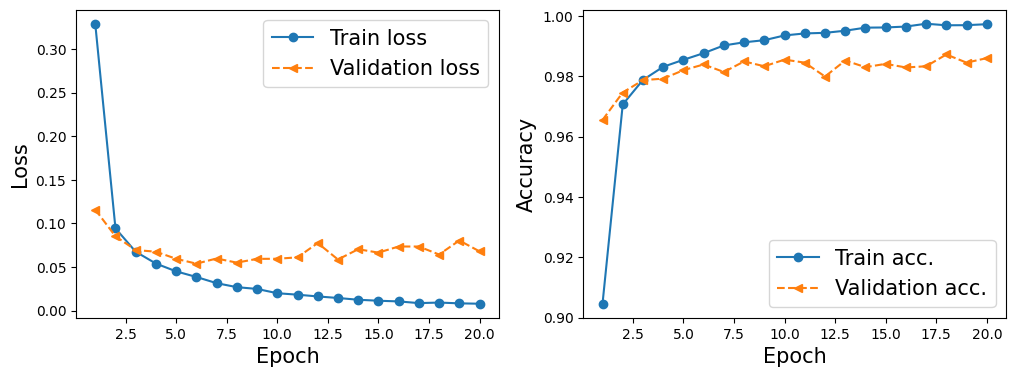

In [ ]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1  # number of epochs

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
# cuda.synchronize()
# It is used to synchronize all CUDA operations.
# When you are running PyTorch on a GPU, operations are often asynchronous for efficiency.
# It ensures that all preceding CUDA operations are finished before moving on, important before switching from GPU to CPU.

torch.cuda.synchronize()

# moves the model from the GPU to the CPU.
model_cpu = model.cpu()


pred = model(mnist_test_dataset.data.unsqueeze(1)/255.)

is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')


Test accuracy: 0.9883


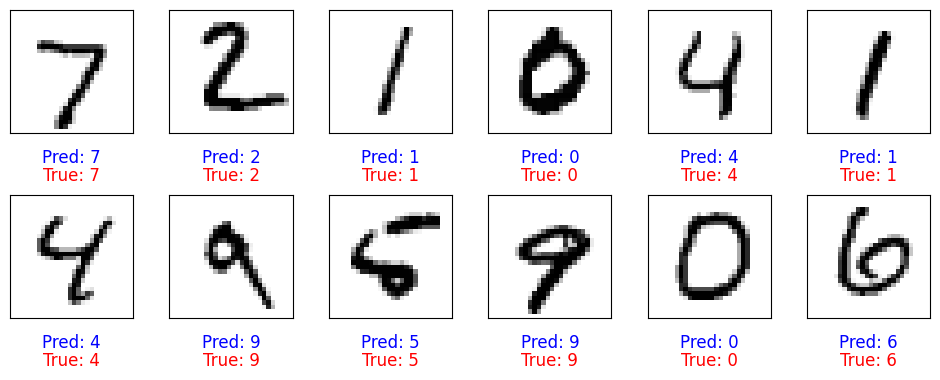

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img, true_label = mnist_test_dataset[i]
    img = img[0, :, :]  # Get the 2D image data from the tensor
    #img = mnist_test_dataset[i][0][0, :, :]   # mnist_test_dataset[i] contain image (tensor) and target (int)
    pred = model(img.unsqueeze(0).unsqueeze(1)) # unsqueeze adds a new dimension to a tensor at a specified position

    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')

    # Add both predicted and ground truth labels to the plot
    ax.text(0.5, -0.2, f'Pred: {y_pred.item()}', size=12, color='blue',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, -0.35, f'True: {true_label}', size=12, color='red',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Adjust vertical spacing between rows (increase hspace)
plt.subplots_adjust(hspace=0.5)  # Increase space between rows (default is 0.2)


plt.show()

### Randomly select an image, rotate, and make prediction

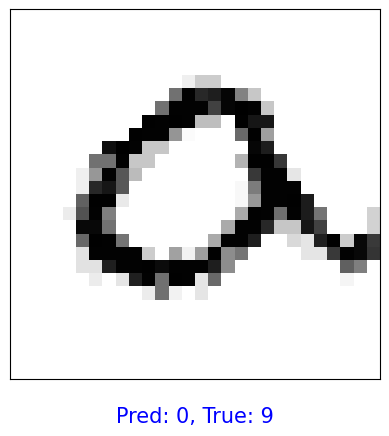

angle: 42.75


In [ ]:
import random
import torchvision.transforms.functional as TF

# Randomly select an image from the MNIST test dataset
random_idx = random.randint(0, len(mnist_test_dataset) - 1)  # Select a random index
img, true_label = mnist_test_dataset[random_idx]  # Get the image and true label
img = img.unsqueeze(0)  # Add batch dimension [1, 1, 28, 28]

# Rotate the image by a random angle
angle = random.uniform(-45, 45)  # Choose a random angle between -90 and 90 degrees
rotated_img = TF.rotate(img, angle)  # Rotate the image

# Make a prediction with the rotated image
pred = model(rotated_img)  # Run through the model
y_pred = torch.argmax(pred)  # Get the predicted label

# Plot the rotated image and show both the prediction and the true label
fig, ax = plt.subplots()
ax.set_xticks([]); ax.set_yticks([])

# Display the rotated image
ax.imshow(rotated_img.squeeze(), cmap='gray_r')

# Show predicted and true labels
ax.text(0.5, -0.1, f'Pred: {y_pred.item()}, True: {true_label}', size=15, color='blue',
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.show()

print(f"angle: {angle:1.2f}")

### CNN For Cifar10 - Exercise

We have provided the loading/splitting of the dataset, along with some analysis code. We want you to focus on the model and see what kind of performance you can get. Consider things like:

1. Dropout
2. BatchNorm2d
3. Depth of Convolutional feature extractor (how many layers)
4. Depth of MLP feature processor (how many layers)

In [ ]:
from torch.utils.data import DataLoader, random_split

# CIFAR-10 class names
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# Data transform (normalize to [-1, 1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Load full CIFAR-10 train/test datasets
full_train_dataset = datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./', train=False, transform=transform, download=True)

# Split train into train/val
train_size = int(0.9 * len(full_train_dataset))  # 45,000
val_size = len(full_train_dataset) - train_size  # 5,000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size]) # Note we use random_split here - a convenient way to do what we did by hand above

# DataLoaders
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
print("Training size: ", len(train_dataset))
print("Validation size: ", len(val_dataset))
print("Test size: ", len(test_dataset))


Training size:  45000
Validation size:  5000
Test size:  10000


If you are not familiar with CIFAR10, lets view some images. We will also notice something very important - we are working with RGB images. This means we will have 3 channels to begin with in our image. You will need to consider this when creating your model, specifically in the intialy Conv layer, and the linear layer after the flattening operation.

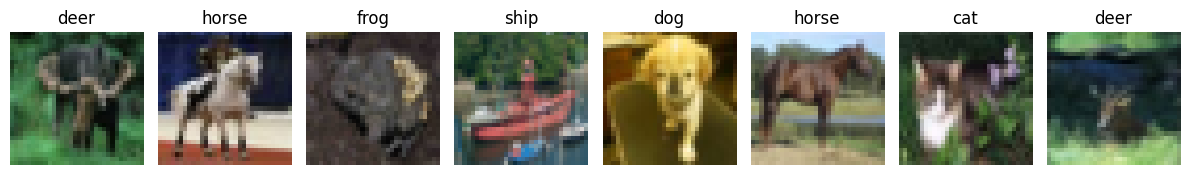

In [ ]:
def imshow(img, mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]):
    """Unnormalize and show an image tensor."""
    img = img.numpy().transpose((1, 2, 0))  # CHW -> HWC
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)

def show_samples(loader, classes, n=8):
    """Display a grid of n images from a DataLoader with their labels."""
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
show_samples(train_dl, cifar10_classes, n=8)

In [ ]:
import torch.nn.functional as F

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

model = CIFAR10_CNN()
model = model.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # model.eval() is a built-in method inherited from nn.Module used to set the model to evaluation mode
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 5
hist = train(model, num_epochs, train_dl, valid_dl)

In [ ]:
x_arr = np.arange(len(hist[0])) + 1  # number of epochs

fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_cifar10_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Total accuracy
    total_acc = (all_preds == all_labels).mean()
    print(f"Total accuracy: {total_acc:.2%}")

    # Per-class accuracy
    per_class_acc = []
    for i, cls in enumerate(class_names):
        idxs = all_labels == i
        cls_acc = (all_preds[idxs] == i).mean() if np.sum(idxs) > 0 else 0
        per_class_acc.append(cls_acc)
        print(f"Accuracy for class {cls}: {cls_acc:.2%}")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return total_acc, per_class_acc, cm


total_acc, per_class_acc, cm = evaluate_cifar10_model(model, test_dl, cifar10_classes, device)


In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img, true_label = test_dataset[i]  # tensor image and true label (int)

    # Predict
    pred = model(img.unsqueeze(0).to(device))
    y_pred = torch.argmax(pred).item()

    # Show image (unnormalize first)
    img_np = img.permute(1, 2, 0).cpu().numpy()
    # Unnormalize: CIFAR-10 was normalized with mean=0.5 and std=0.5
    img_np = img_np * 0.5 + 0.5
    img_np = img_np.clip(0, 1)
    ax.imshow(img_np)

    # Map label indices to text names
    true_label_name = cifar10_classes[true_label]
    pred_label_name = cifar10_classes[y_pred]

    ax.text(0.5, -0.2, f'Pred: {pred_label_name}', size=12, color='blue',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(0.5, -0.35, f'True: {true_label_name}', size=12, color='red',
            horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.subplots_adjust(hspace=0.5)
plt.show()